In [ ]:
import sys
sys.path.append('/Users/karl/mrl/')

In [ ]:
from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *

//anaconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [ ]:
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *

In [ ]:
from torch.distributions import Normal

In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        raise NotImplementedError
        
    def get_latent(self, mu, logvar):
        z = torch.randn(mu.shape).to(mu.device)
        z = mu + z*torch.exp(0.5*logvar)
        kl_loss = 0.5 * (logvar.exp() + mu.pow(2) - 1 - logvar).sum(1).mean()
        return z, kl_loss
        
class VAELSTMEncoder(VAEEncoder):
    def __init__(self, d_vocab, d_embedding, d_hidden, n_layers, d_latent, dropout=0.):
        super().__init__()
        
        self.embedding = nn.Embedding(d_vocab, d_embedding)
        self.lstm_encoder = LSTM(d_embedding, d_hidden, d_hidden, n_layers, 
                                 bidir=True, batch_first=True, dropout=dropout)
        self.transition = nn.Linear(d_hidden*2, d_latent*2)
        
        
    def forward(self, x):
        x = self.embedding(x)
        x, hiddens = self.lstm_encoder(x)
        hidden = torch.cat(list(torch.cat(hiddens[-1], -1)), -1) # concatenate hidden/cell states of last layer
        
        mu, logvar = torch.chunk(self.transition(hidden), 2, dim=-1)
        z, kl_loss = self.get_latent(mu, logvar)
        
        return z, kl_loss
              
class VAEConvEncoder(VAEEncoder):
    def __init__(self, d_vocab, d_embedding, kernel_size, n_layers, d_latent, dropout=0.):
        super().__init__()
    
        self.embedding = nn.Embedding(d_vocab, d_embedding)

        convs = []
        input_size = d_embedding
        for i in range(n_layers):
            convs.append(Conv1d(input_size, input_size*2, ks=kernel_size, stride=2, 
                                act=True, bn=True, dropout=dropout))
            input_size = input_size*2

        self.convs = nn.Sequential(*convs)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.transition = nn.Linear(input_size, d_latent*2)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0,2,1)
        x = self.convs(x)
        x = self.pool(x).squeeze(-1)
        
        mu, logvar = torch.chunk(self.transition(x), 2, dim=-1)
        z, kl_loss = self.get_latent(mu, logvar)
        
        return z, kl_loss
              
class VAELinEncoder(VAEEncoder):
    def __init__(self, d_input, n_layers, d_latent, dropout=0.):
        super().__init__()
    
        lins = []
        input_size = d_input
        for i in range(n_layers):
            lins.append(Linear(input_size, input_size//2, act=True, bn=True, dropout=dropout))
            input_size = input_size//2
            
        self.layers = nn.Sequential(*lins)
        self.transition = nn.Linear(input_size, d_latent*2)
    
    def forward(self, x):
        x = self.layers(x)
        
        mu, logvar = torch.chunk(self.transition(x), 2, dim=-1)
        z, kl_loss = self.get_latent(mu, logvar)
        
        return z, kl_loss

In [ ]:
class VAEDecoder(nn.Module):
    def __init__(self, d_vocab, d_embedding, d_hidden, n_layers, d_latent,
                condition_hidden=True, condition_output=True):
        super().__init__()
        
        self.embedding = nn.Embedding(d_vocab, d_embedding)
        self.decoder = Conditional_LSTM(d_embedding, d_hidden, d_embedding, d_latent, 3, 
                                    condition_hidden=condition_hidden, condition_output=condition_output, 
                                    bidir=False, batch_first=True)
        
        self.head = Linear(d_embedding, d_vocab, act=False, bn=False, dropout=0.)
        
    def forward(self, x, z, hiddens=None):
        bs, sl = x.shape
        x = self.embedding(x)
        
        decoded, hiddens = self.decoder(x, z, hiddens)
        output = self.head(decoded)
        
        return output, hiddens

In [ ]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x, decoder_input=None):
        z, kl_loss = self.encoder(x)
        
        if decoder_input is None:
            decoder_input = x
            
        output, hiddens = self.decoder(decoder_input, z)
        return output, kl_loss

In [ ]:
df = pd.read_csv('../nbs/files/smiles.csv')

In [ ]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

In [ ]:
data = TextDataset(df.smiles.values, vocab)

In [ ]:
dl = data.dataloader(32)

In [ ]:
x,y = next(iter(dl))

In [ ]:
# encoder = VAELSTMEncoder(len(vocab.itos), 256, 1024, 3, 512)
encoder = VAEConvEncoder(len(vocab.itos), 256, 7, 3, 512)
decoder = VAEDecoder(len(vocab.itos), 256, 1024, 3, 512, condition_hidden=True, condition_output=True)
model = VAE(encoder, decoder)

In [ ]:
with torch.no_grad():
    out = model(x)

In [ ]:
data = FPReconstructionDataset(df.smiles.values, vocab, ECFP6)

In [ ]:
dl = data.dataloader(32)

In [ ]:
x,y = next(iter(dl))

In [ ]:
x.shape, y.shape

(torch.Size([32, 2048]), torch.Size([32, 67]))

In [ ]:
encoder = VAELinEncoder(2048, 2, 512)
decoder = VAEDecoder(len(vocab.itos), 256, 1024, 3, 512, condition_hidden=True, condition_output=True)
model = VAE(encoder, decoder)

In [ ]:
with torch.no_grad():
    out = model(x,y)

In [ ]:
out[-1]

tensor(66.2236)

In [ ]:
out[0].shape

torch.Size([32, 67, 42])

In [ ]:
inputs:
    None (sample prior)
    latents (from somewhere)
    smiles
    
sample outputs

In [ ]:

    

        
        
class VAE(nn.Module):
    def __init__(self, encoder, decoder, d_latent, bos_idx=0):
        super().__init__(self)
        
        self.encoder = encoder
        self.decoder = decoder
        self.bos_idx = bos_idx
#         self.prior = Normal(torch.tensor([0.0]*d_latent), torch.tensor([1.0]*d_latent))
        
    def forward(self, x):
        z, kl_loss = self.encoder(x)
        output = self.decoder(x, z)
        return output, kl_loss
    
    
    def sample(self, bs, sl, temperature=1., multinomial=True):
        
        preds = idxs = to_device(torch.tensor([self.bos_idx]*bs).long().unsqueeze(-1))
        lps = []

        hiddens = None
        z = self.prior.sample(bs)
        
        for i in range(sl):
            x = self.decoder(idxs, z, hiddens)
            x.div_(temperature)
            
            log_probs = F.log_softmax(x, -1).squeeze(1)
            probs = log_probs.detach().exp()
            
            if multinomial:
                idxs = torch.multinomial(probs, 1)
            else:
                idxs = x.argmax(-1)
                
            lps.append(torch.gather(log_probs, 1, idxs))
            
            preds = torch.cat([preds, idxs], -1)
            
        return preds[:, 1:], torch.cat(lps,-1)
    
    def sample_no_grad(self, bs, sl, temperature=1., multinomial=True):
        with torch.no_grad():
            return self.sample(bs, sl, temperature=temperature, multinomial=multinomial)
        
    def get_lps(self, x, y, temperature=1.):
        x = self.forward(x)
        x.div_(temperature)
        
        lps = F.log_softmax(x, -1)
        lps = lps.gather(2, y.unsqueeze(-1)).squeeze(-1)
        
        return lps
    
class TrainablePrior(nn.Module):
    def __init__(self, vae, d_latent, prior=None):
        super().__init__()
        
        self.vae = vae
        self.d_latent = d_latent
        
        if prior is None:
            prior = Normal(torch.tensor([0.0]*d_latent), torch.tensor([1.0]*d_latent))
            
        self.prior = prior
        
    def forward(self, x):
        raise NotImplementedError


VAE questions

sampling from nothing vs latents vs smiles

best saampling procedure. ie we saample some from latent space (latent to smilles), some from explore straat (smiles to llatent to smilles)

scale of noise on latent

getting log prob of prior vs 

conditional LSTM class - condition on hidden or on decode

In [ ]:
df = pd.read_csv('../nbs/files/smiles.csv')

In [ ]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

In [ ]:
data = TextDataset(df.smiles.values, vocab)

In [ ]:
dl = data.dataloader(32)

In [ ]:
x,y = next(iter(dl))

In [ ]:
enc = VAELSTMEncoder(len(vocab.itos), 256, 1024, 3, 512)

In [ ]:
out = enc(x)

In [ ]:
out[0].shape

torch.Size([32, 512])

In [ ]:
out[1]

tensor(0.3213, grad_fn=<MulBackward0>)

In [ ]:
enc = VAEConvEncoder(len(vocab.itos), 256, 7, 3, 512)

In [ ]:
out = enc(x)

In [ ]:
out[0].shape, out[1]

(torch.Size([32, 512]), tensor(24.9031, grad_fn=<MulBackward0>))

In [ ]:
data = FPReconstructionDataset(df.smiles.values, vocab, ECFP6)

In [ ]:
dl = data.dataloader(32)

In [ ]:
x,y = next(iter(dl))
x.shape, y.shape

(torch.Size([32, 2048]), torch.Size([32, 67]))

In [ ]:
enc = VAELinEncoder(2048, 3, 512)

In [ ]:
enc(x)

(tensor([[-0.7992,  0.8107, -0.6547,  ...,  0.3234,  1.5410, -0.3869],
         [-1.7719, -0.4245,  1.9757,  ...,  0.7609, -0.6874,  0.3805],
         [-1.7048,  1.0605,  2.8063,  ..., -1.6529, -0.7574, -0.9330],
         ...,
         [ 1.1450, -0.6193, -1.9589,  ..., -1.1366,  0.7022,  2.8290],
         [ 1.2373,  3.1392, -0.9202,  ...,  0.5538,  1.6990, -1.0942],
         [-0.0762,  0.0967,  2.3909,  ..., -0.3375,  1.1847,  0.1257]],
        grad_fn=<AddBackward0>), tensor(64.6368, grad_fn=<MulBackward0>))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
from mrl.dataloaders import *
from mrl.chem import *
from mrl.core import *

In [ ]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

In [ ]:
model = LSTMLM(len(vocab.itos), 256, 1024, 3, vocab.stoi['pad'])

In [ ]:
model.load_state_dict(torch.load('untracked_files/smiles_lm.pt'))

<All keys matched successfully>

In [ ]:
model.cuda();

In [ ]:
from mrl.templates import *

In [ ]:
# template = Template([ValidityFilter(), SingleCompoundFilter()],
#                     [QEDFilter(None, None, score=PassThroughScore()),
#                      SAFilter(None, None, 
#                               score=PropertyFunctionScore(lambda x: (10-x)/9))], fail_score=-1.)

template = Template([ValidityFilter(), SingleCompoundFilter()],
                    [FPFilter.from_smiles(['CCN(CC)C(=O)C1CN(C2Cc3c[nH]c4c3c(ccc4)C2=C1)C',
                                           'CCN(CC)C(=O)C1CN(C2Cc3c[nH]c4c3c(ccc4)C2=C1)C'],
                        score=PropertyFunctionScore(lambda x: x.max()))], fail_score=-1.)



In [ ]:
preds, lps = model.sample_no_grad(100,100)
smiles = [vocab.reconstruct(i) for i in preds]

In [ ]:
os.environ['ncpus'] = '0'

In [ ]:
lps[0]

tensor([-1.2723e-01, -1.7745e+00, -8.4397e-01, -1.4067e-05, -4.9586e-02,
        -5.0757e-02, -3.1345e-01, -5.1511e-01, -2.1337e+00, -4.2084e-01,
        -2.9031e-02, -4.2183e-02, -4.1649e-02, -4.2915e-06, -9.7015e-01,
        -7.6850e-01, -2.3939e-02, -4.6610e-05, -5.0068e-06, -4.6310e-03,
        -1.2957e+00, -1.2310e-02, -1.6524e-01, -2.5445e+00, -4.6870e-01,
        -4.6492e-06, -1.5020e-05, -8.2051e-01, -1.9669e-05, -5.8349e-02,
        -2.2157e+00, -7.0333e-06, -5.9605e-07, -6.9516e-01, -3.3731e-04,
        -2.7418e-06, -5.3541e-01, -2.4554e-04, -1.6570e-05, -8.4332e-02,
        -7.7576e-01, -5.1260e-06, -3.1828e-05, -1.2875e-05, -1.0827e-02,
        -4.4455e-01, -3.4791e-04, -2.1357e+00, -1.2579e+00, -3.5405e-05,
        -1.5210e-04, -1.5497e-06, -3.9339e-06, -7.4573e-04, -1.8477e-05,
        -4.4107e-06, -1.0014e-05, -3.5763e-07,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

In [ ]:
data = TextDataset(smiles, vocab)

In [ ]:
x,y = data.collate_function([data[i] for i in range(len(data))])

In [ ]:
with torch.no_grad():
    out = model(x.cuda())

In [ ]:
out.shape

torch.Size([100, 71, 42])

In [ ]:
y.shape

torch.Size([100, 71])

In [ ]:
lps.shape

torch.Size([100, 100])

In [ ]:
out = F.log_softmax(out, -1)

In [ ]:
out.gather(2, y.cuda().unsqueeze(-1)).squeeze(-1)[0]

tensor([-1.2723e-01, -1.7745e+00, -8.4397e-01, -1.4067e-05, -4.9586e-02,
        -5.0757e-02, -3.1345e-01, -5.1511e-01, -2.1337e+00, -4.2084e-01,
        -2.9031e-02, -4.2183e-02, -4.1649e-02, -4.2915e-06, -9.7015e-01,
        -7.6850e-01, -2.3939e-02, -4.6610e-05, -5.0068e-06, -4.6310e-03,
        -1.2957e+00, -1.2310e-02, -1.6524e-01, -2.5445e+00, -4.6870e-01,
        -4.6492e-06, -1.5020e-05, -8.2051e-01, -1.9669e-05, -5.8349e-02,
        -2.2157e+00, -7.0333e-06, -5.9605e-07, -6.9516e-01, -3.3731e-04,
        -2.7418e-06, -5.3541e-01, -2.4554e-04, -1.6570e-05, -8.4332e-02,
        -7.7576e-01, -5.1260e-06, -3.1828e-05, -1.2875e-05, -1.0827e-02,
        -4.4455e-01, -3.4791e-04, -2.1357e+00, -1.2579e+00, -3.5405e-05,
        -1.5210e-04, -1.5497e-06, -3.9339e-06, -7.4573e-04, -1.8477e-05,
        -4.4107e-06, -1.0014e-05, -3.5763e-07,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

In [ ]:
lps[0]

tensor([-1.2723e-01, -1.7745e+00, -8.4397e-01, -1.4067e-05, -4.9586e-02,
        -5.0757e-02, -3.1345e-01, -5.1511e-01, -2.1337e+00, -4.2084e-01,
        -2.9031e-02, -4.2183e-02, -4.1649e-02, -4.2915e-06, -9.7015e-01,
        -7.6850e-01, -2.3939e-02, -4.6610e-05, -5.0068e-06, -4.6310e-03,
        -1.2957e+00, -1.2310e-02, -1.6524e-01, -2.5445e+00, -4.6870e-01,
        -4.6492e-06, -1.5020e-05, -8.2051e-01, -1.9669e-05, -5.8349e-02,
        -2.2157e+00, -7.0333e-06, -5.9605e-07, -6.9516e-01, -3.3731e-04,
        -2.7418e-06, -5.3541e-01, -2.4554e-04, -1.6570e-05, -8.4332e-02,
        -7.7576e-01, -5.1260e-06, -3.1828e-05, -1.2875e-05, -1.0827e-02,
        -4.4455e-01, -3.4791e-04, -2.1357e+00, -1.2579e+00, -3.5405e-05,
        -1.5210e-04, -1.5497e-06, -3.9339e-06, -7.4573e-04, -1.8477e-05,
        -4.4107e-06, -1.0014e-05, -3.5763e-07,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
all_scores = []

for i in range(100):
        
    preds, lps = model.sample_no_grad(512,90)
    smiles = [vocab.reconstruct(i) for i in preds]
    
    if np.random.rand(1)<0.05:
        print('seeding')
        smiles.append('CCN(CC)C(=O)C1CN(C2Cc3c[nH]c4c3c(ccc4)C2=C1)C')

    passes, fails = template.screen_mols(smiles)

    if passes:
        smiles = [i[0] for i in passes]
        scores = np.array([i[1] for i in passes])

        data = TextDataset(smiles, vocab)

        x,y = data.collate_function([data[i] for i in range(len(data))])

        lps = model(x.cuda())
        lps = F.log_softmax(lps, -1)
        lps = lps.gather(2, y.cuda().unsqueeze(-1)).squeeze(-1)

        all_scores.append(scores)
        scores = scores - scores.mean()

        opt.zero_grad()
        loss = -(lps.sum(-1))*torch.from_numpy(scores).cuda()
        loss = loss.mean()
        loss.backward()
        opt.step()

    if i%10==0:
        print(i, all_scores[-1].mean())

0 0.10146588268993592
10 0.1338634037010431
seeding
20 0.273065905888256
30 0.3125
40 0.3478260869565218
seeding
seeding
50 0.3492438563327031
seeding
seeding
60 0.3462030604883481
70 0.3478260869565217
seeding
80 0.3478260869565217
seeding
seeding
90 0.34734440309388576


In [ ]:
template.soft_log[template.soft_log.final>0.3]

,smiles,0,final
8527,CCN(CC)C(=O)C1C=C2c3cccc4[nH]cc(c34)CC2N(C)C1,1.000000,1.000000
8601,CCN(C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN(C)C1,0.312500,0.312500
8667,CCN(C(=O)c1c[nH]c2cccc(C(=O)O)c12)N1C[C@H](C)C...,0.303030,0.303030
8668,CCN(C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN(C)N1,0.309278,0.309278
8686,CCN(C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN1C,0.347826,0.347826
8690,CCN(C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN(C)S1(=O)=O,0.313131,0.313131
8693,CCN(C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN1N,0.302083,0.302083
8696,CCN(CC)C(=O)c1c[nH]c2cccc(C(=O)O)c12,0.310345,0.310345
8720,CCN(C(=O)C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN1C,0.340426,0.340426


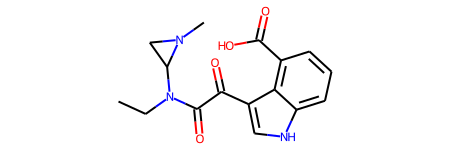

In [ ]:
to_mol('CCN(C(=O)C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN1C')

torch/models roadmap

torch_core
    tensor operations
    gather
    
dataloaders
    vocab
    dataset
    dataloader

models
    LSTM LM
    VAE
    transformer
    contain supervised training loop
    dataset/dataloader

fastai

move onto torch/models
get protein model running
come back to chem/templates, remake with protein variants. code will hopefully be simpler


get collab working
get google search working

torch core
models (lstm, vae, transformer)
    work in protein stuff here

score functions

training loop

poicy gradients

q-network

diff-loss

exploration strategies

combichem

pharmacophore 


pages
overview

generrative screening primerr

In [ ]:
(math.tanh((step - 15000)/1000) + 1) / 2

In [ ]:
import math

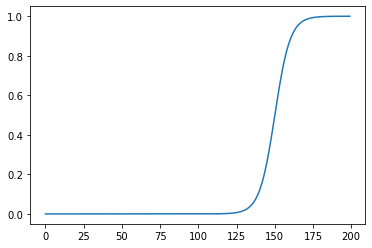

In [ ]:
plt.plot([(math.tanh((step - 15000)/1000) + 1) / 2 for step in range(0,20000,100)])